In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib.dates as mdates

In [2]:
%matplotlib notebook

In [3]:
cvd = pd.read_csv("04_07_2021.csv").sort_values("date")
cvd = cvd.iloc[cvd.date.values >= 20200316]

In [4]:
cvd.columns

Index(['Unnamed: 0', 'date', 'state', 'positive', 'probableCases', 'negative',
       'pending', 'totalTestResultsSource', 'totalTestResults',
       'hospitalizedCurrently', 'hospitalizedCumulative', 'inIcuCurrently',
       'inIcuCumulative', 'onVentilatorCurrently', 'onVentilatorCumulative',
       'recovered', 'lastUpdateEt', 'dateModified', 'checkTimeEt', 'death',
       'hospitalized', 'hospitalizedDischarged', 'dateChecked',
       'totalTestsViral', 'positiveTestsViral', 'negativeTestsViral',
       'positiveCasesViral', 'deathConfirmed', 'deathProbable',
       'totalTestEncountersViral', 'totalTestsPeopleViral',
       'totalTestsAntibody', 'positiveTestsAntibody', 'negativeTestsAntibody',
       'totalTestsPeopleAntibody', 'positiveTestsPeopleAntibody',
       'negativeTestsPeopleAntibody', 'totalTestsPeopleAntigen',
       'positiveTestsPeopleAntigen', 'totalTestsAntigen',
       'positiveTestsAntigen', 'fips', 'positiveIncrease', 'negativeIncrease',
       'total', 'totalT

In [5]:
def moving_average(x, y, n):
    return np.array([np.mean(y[np.absolute(x - xi) <= n]) for xi in x])

# Positive Cases

In [6]:
cvd["date2"] = np.array([datetime.strptime(str(d), '20%y%m%d') for d in cvd.date.values])

In [7]:
np.max(cvd.date2.values)

numpy.datetime64('2021-03-07T00:00:00.000000000')

<IPython.core.display.Javascript object>


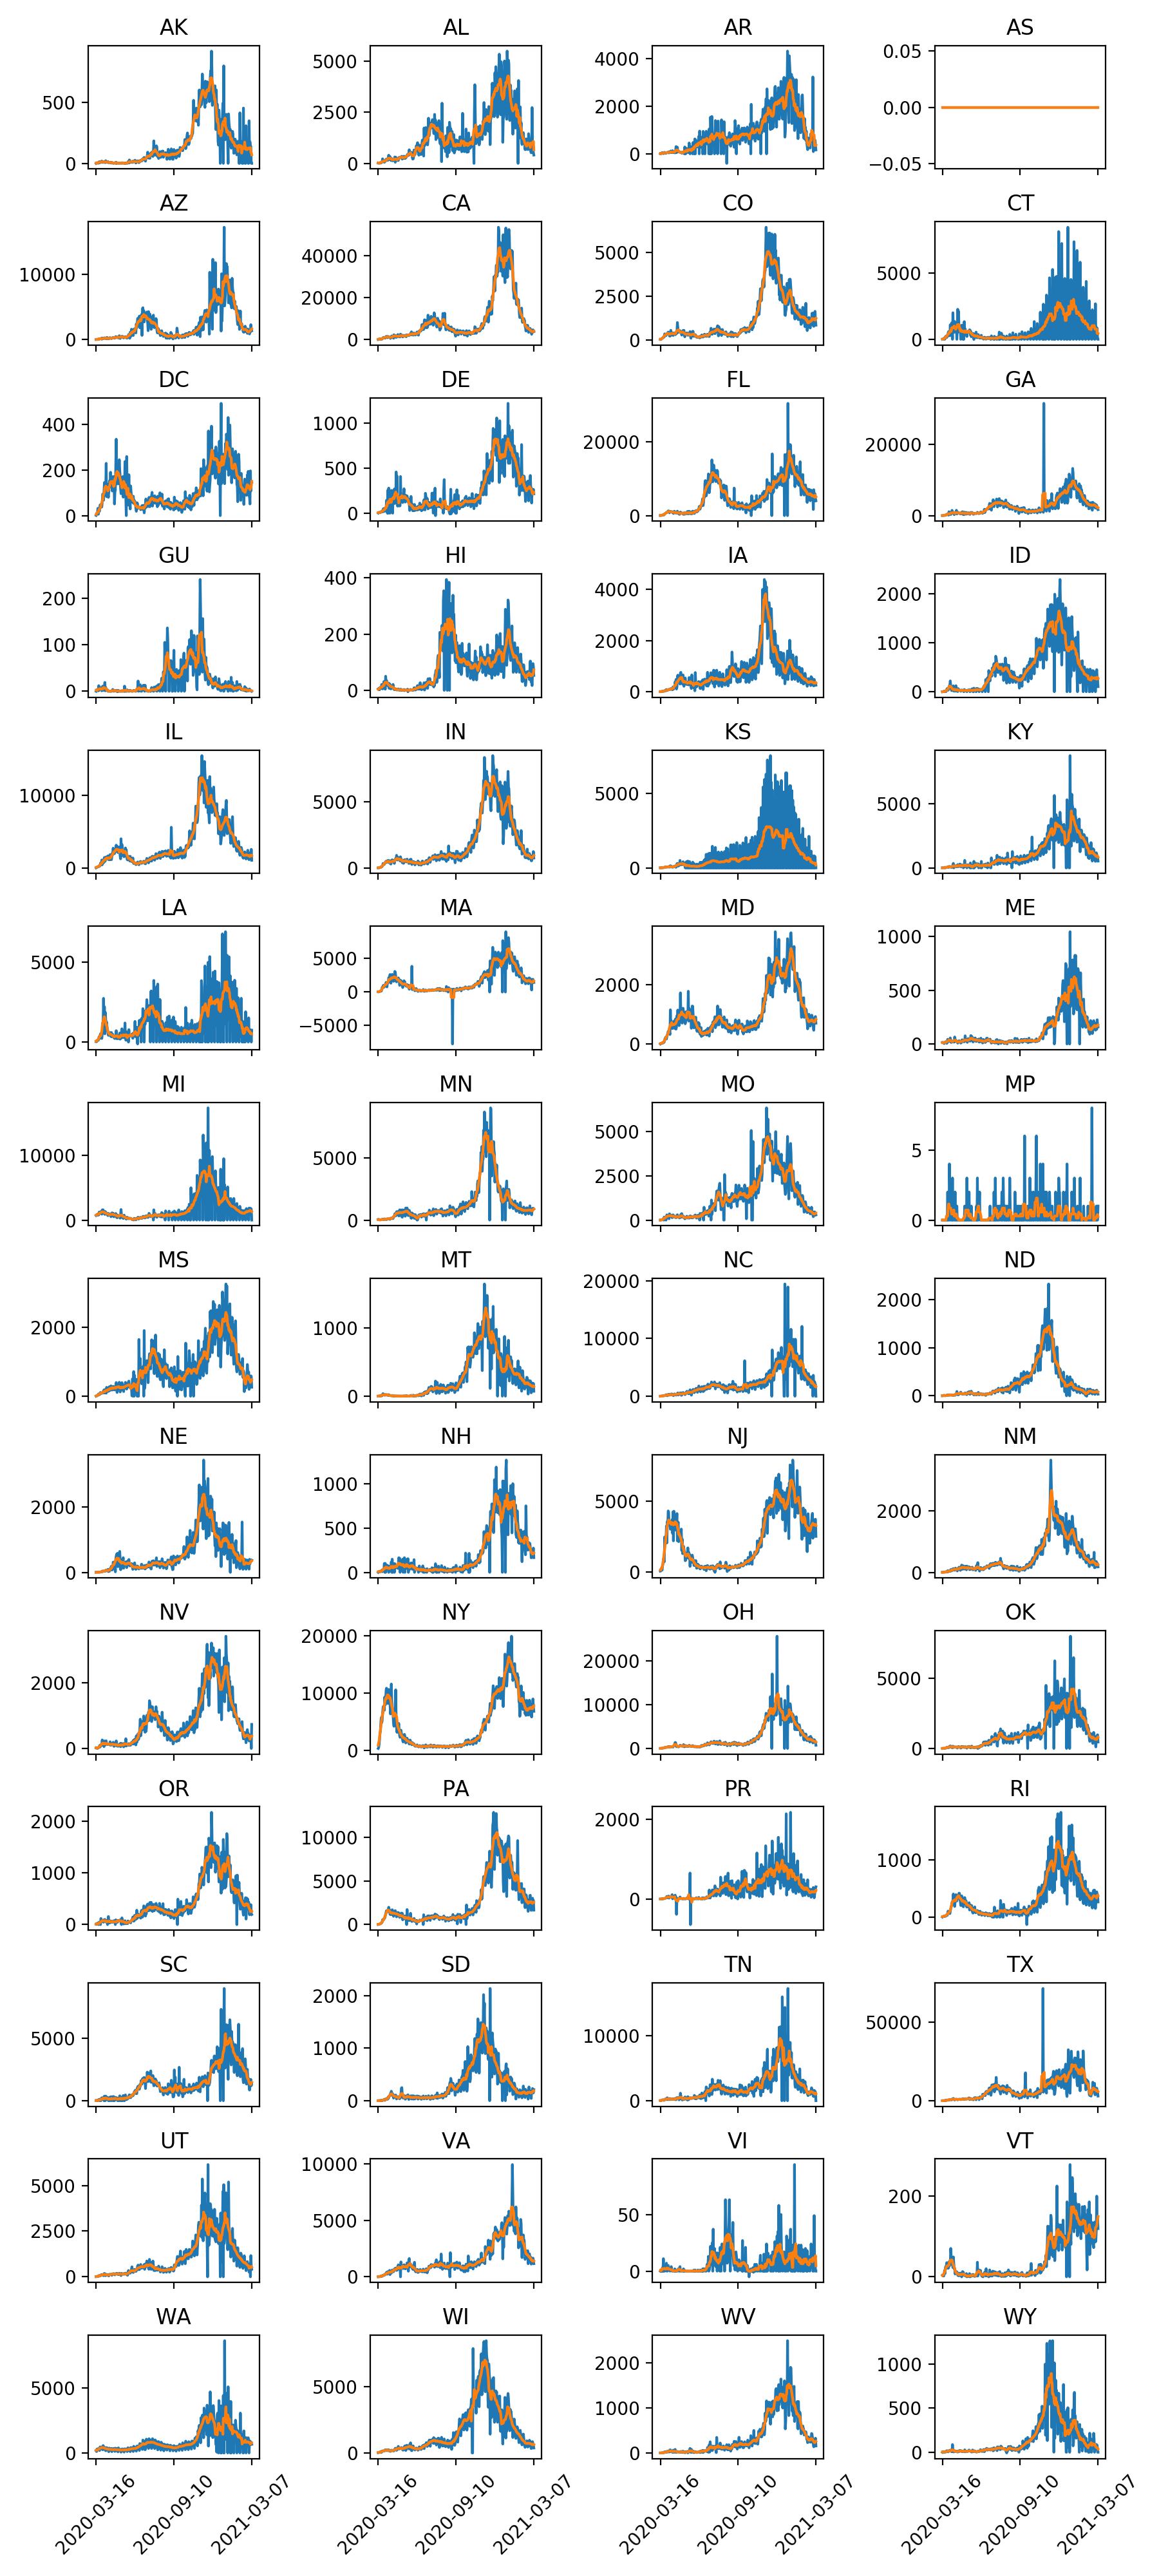

In [8]:
fig, ax = plt.subplots(14,4, sharex=True, figsize=(9,20))

X = []
for i, s in enumerate(np.unique(cvd.state.values)):
    these = np.where(cvd.state.values == s)[0]
    ax[int(i/4),i%4].plot(cvd.iloc[these].date2.values,cvd.iloc[these].positiveIncrease.values)
    ax[int(i/4),i%4].plot(cvd.iloc[these].date2.values,moving_average(np.arange(len(these)),
                                                                      cvd.iloc[these].positiveIncrease.values,3))
    ax[int(i/4),i%4].set_title(s, fontsize=12)
    X.append(moving_average(np.arange(len(these)),cvd.iloc[these].positiveIncrease.values,3))
    ax[int(i/4),i%4].set_xticks(cvd.iloc[these].date2.values[np.array([0,int(len(these)/2),len(these)-1])])
    #ax[int(i/4),i%4].set_xticklabels(,rotation=45)
    
    for tick in ax[int(i/4),i%4].get_xticklabels():
        tick.set_rotation(45)
X = np.array(X)
plt.tight_layout()
plt.show()

Since each positive case of COVID-19 is not reported to the state right as it begins, and since some states don't immediately report their case counts to the national public, we need to take the 'date' variable with a grain of salt. GA, MA, and TX are three that give a pretty clear visual example for the need to smooth the data first due to heavy outliers. Other states such as CT and KS seem to only report updates once every couple days. Like is done in The New York Times, we apply a 7-day running average to the positive cases.

To uncover patterns of COVID-19 positive cases across the U.S. states and territories, we use dictionary learning. 

In [9]:
from sklearn.decomposition import DictionaryLearning
dict_learner = DictionaryLearning(n_components=15, transform_algorithm='lasso_lars', random_state=42)
X_transformed = dict_learner.fit_transform(X)
comp = dict_learner.components_

## How many components does it take to describe the data?

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


<IPython.core.display.Javascript object>


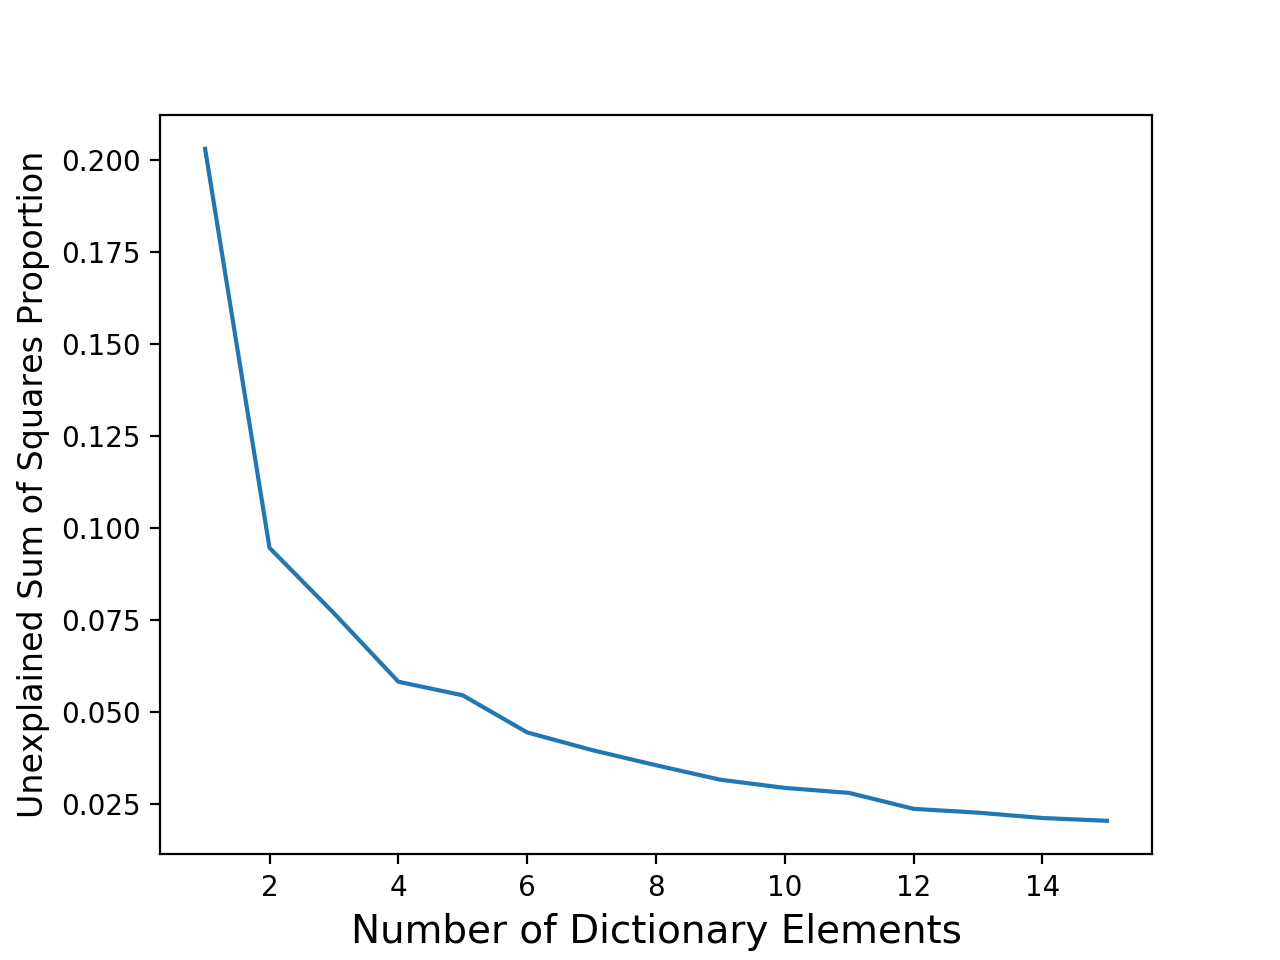

In [10]:
p = []
for i in range(1,16):
    fitted = X_transformed[:,:i] @ comp[:i,:]
    resid = X - fitted
    p.append(np.sum(resid**2, axis=1)/np.sum(X**2, axis=1))
p = np.array(p)
plt.plot(np.arange(1,16),np.nanmean(p, axis=1))
plt.xlabel("Number of Dictionary Elements", fontsize=14)
plt.ylabel("Unexplained Sum of Squares Proportion", fontsize=12)
plt.show()

## What do the dictionary elements look like?

<IPython.core.display.Javascript object>


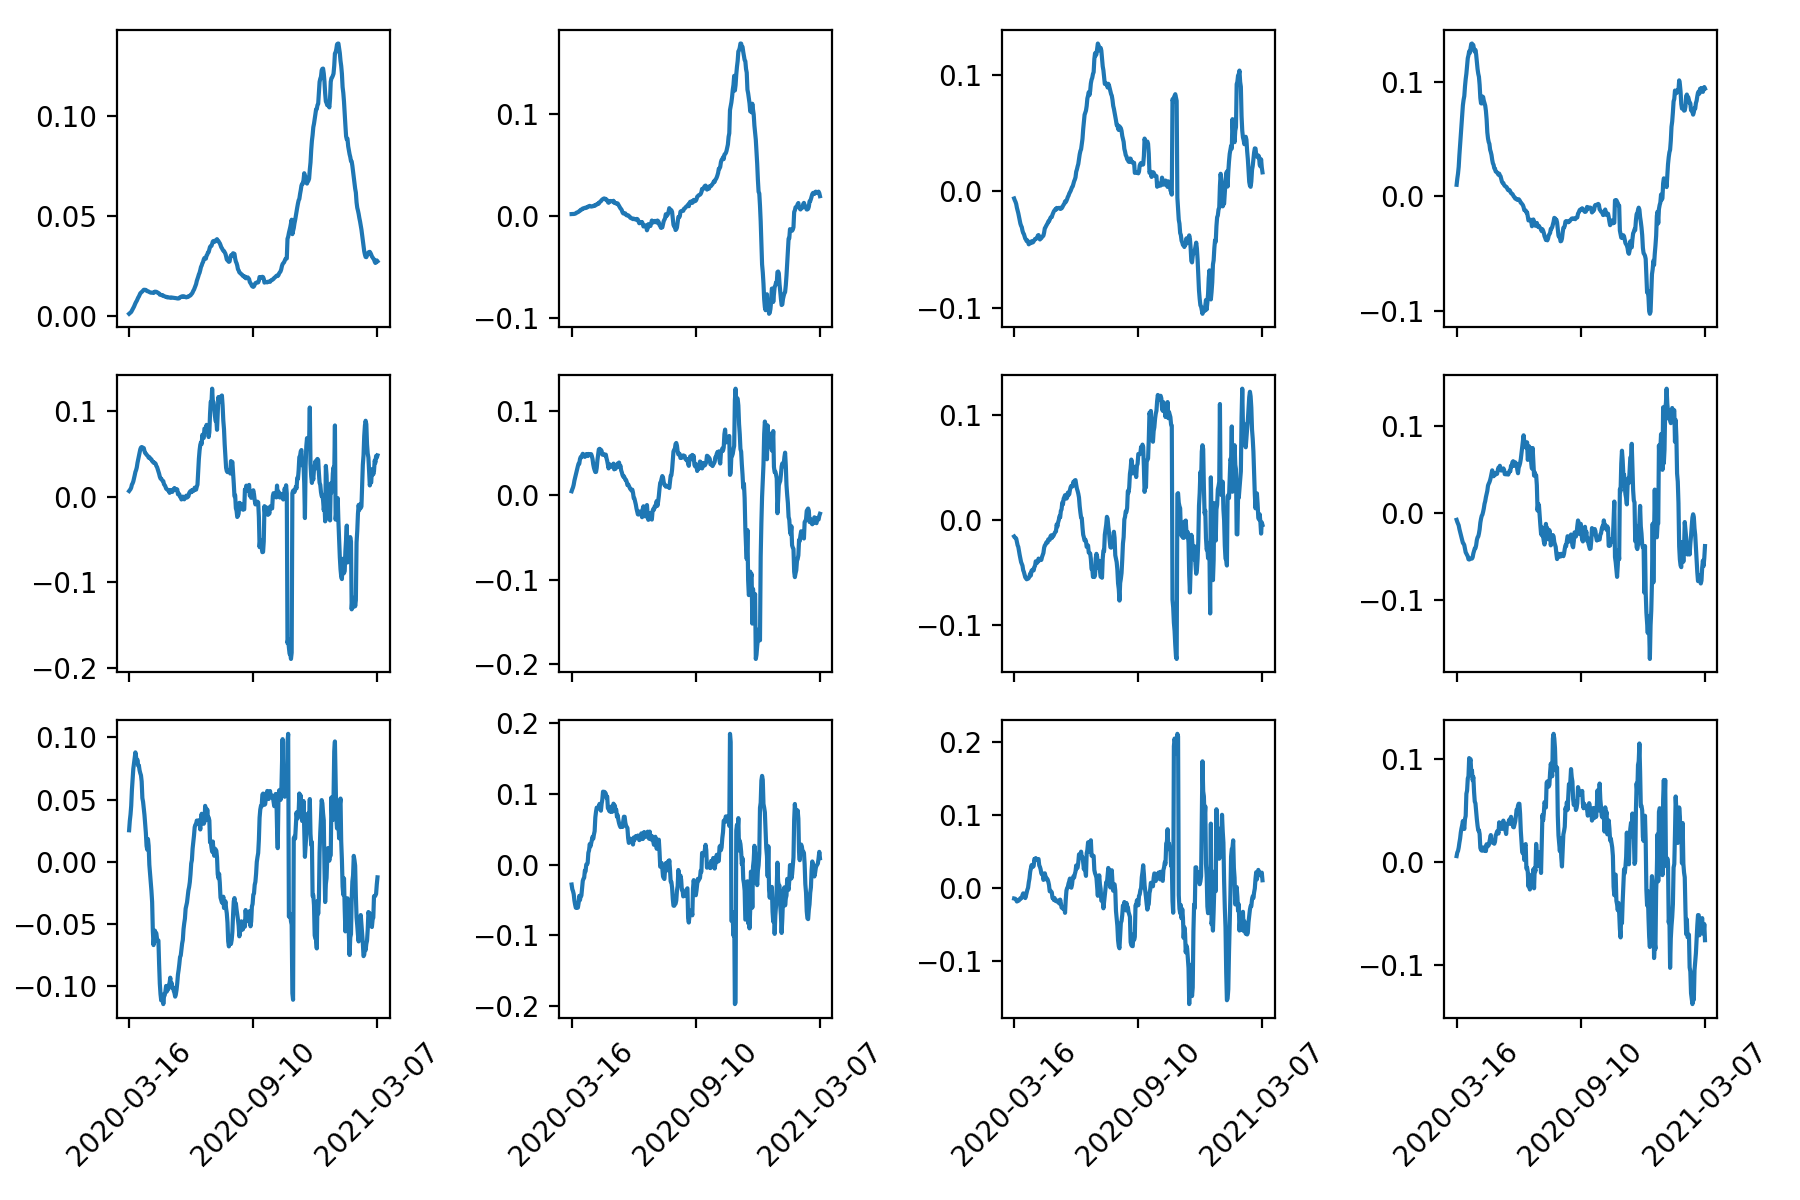

In [11]:
fig, ax = plt.subplots(3,4, sharex=True, figsize=(9,6))
for i in range(12):
    ax[int(i/4),i%4].plot(cvd.iloc[these].date2.values,-comp[i,:])
    ax[int(i/4),i%4].set_xticks(cvd.iloc[these].date2.values[np.array([0,int(len(these)/2),len(these)-1])])
    for tick in ax[int(i/4),i%4].get_xticklabels():
        tick.set_rotation(45)
plt.tight_layout()
plt.show()

Interesting! The first four look smooth enough to tell a story, but the rest don't look quite as pretty. Let's take a closer look at each of them to see what those stories are!

## First Dictionary Element

<IPython.core.display.Javascript object>


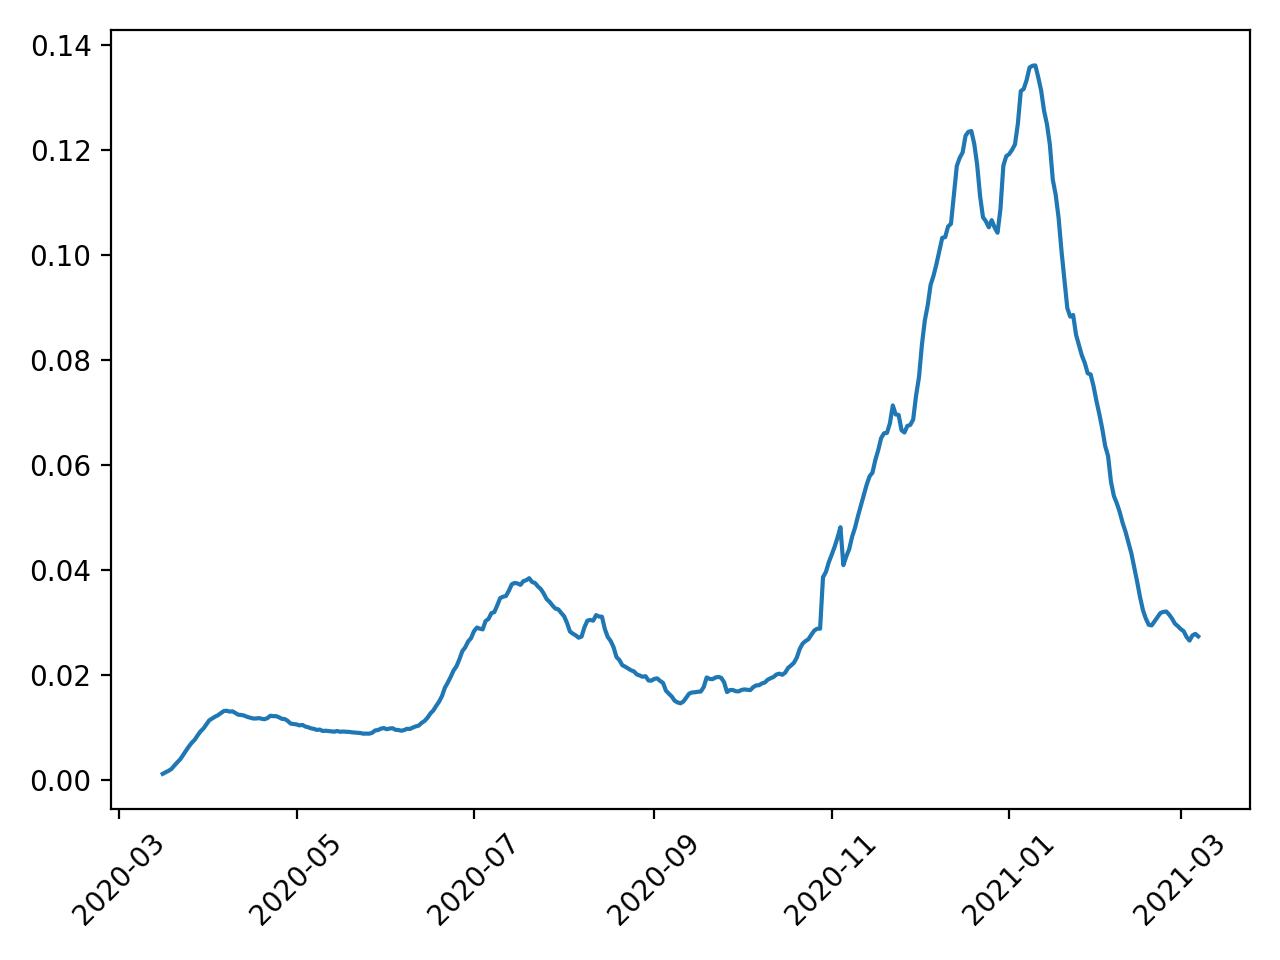

In [12]:
plt.plot(cvd.iloc[these].date2.values,-comp[0,:])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

This first component looks like it tells the story of the overall average trend throughout the U.S. An initial increase in March that primarily happened in the states around New York and Washington, followed by a very gradual decline. And then at the beginning of the summer a second wave that was mostly concentrated in the South and West. Then around the close of September, 2020 an overall countrywide wave started. Interestingly enough, the upticks from Christmas gatherings is rather obvious.

### Which states followed the average overall trend?

In [13]:
for i, s in enumerate(np.unique(cvd.state.values)):
    if np.sum((X[i,:] - X_transformed[i,0]*comp[0,:])**2)/np.sum(X[i,:]**2) < 0.05:
        print(i,s)

1 AL
2 AR
5 CA
9 DE
28 MS
30 NC


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


<IPython.core.display.Javascript object>


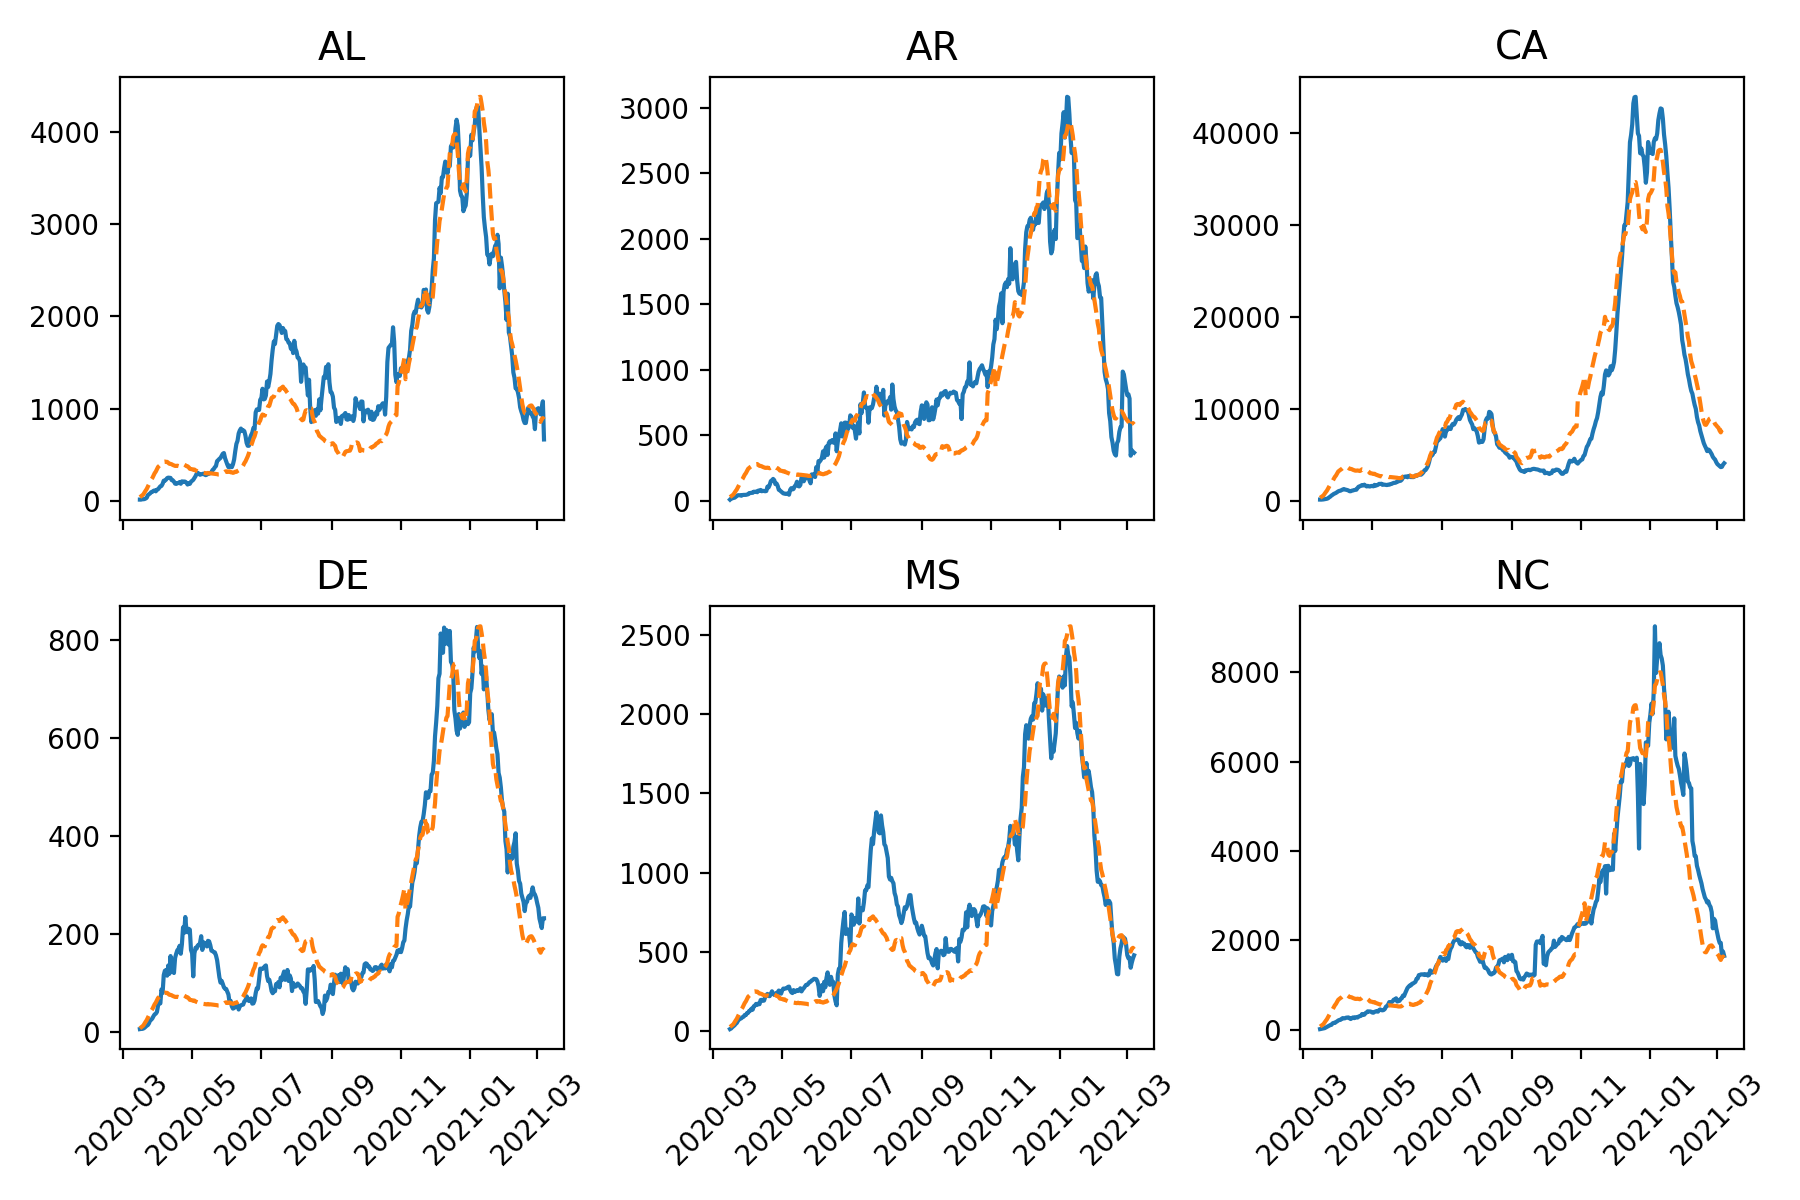

In [14]:
fig, ax = plt.subplots(2,3,sharex=True, figsize=(9,6))

for k,i in enumerate([1,2,5,9,28,30]):
    ax[int(k/3),k%3].plot(cvd.iloc[these].date2.values,X[i,:])
    ax[int(k/3),k%3].plot(cvd.iloc[these].date2.values,X_transformed[i,0] * comp[0,:], ls='--')
    ax[int(k/3),k%3].set_title(np.unique(cvd.state.values)[i], fontsize=14)
    for tick in ax[int(k/3),k%3].get_xticklabels():
        tick.set_rotation(45)
plt.tight_layout()
plt.show()

## Second Dictionary Element

<IPython.core.display.Javascript object>


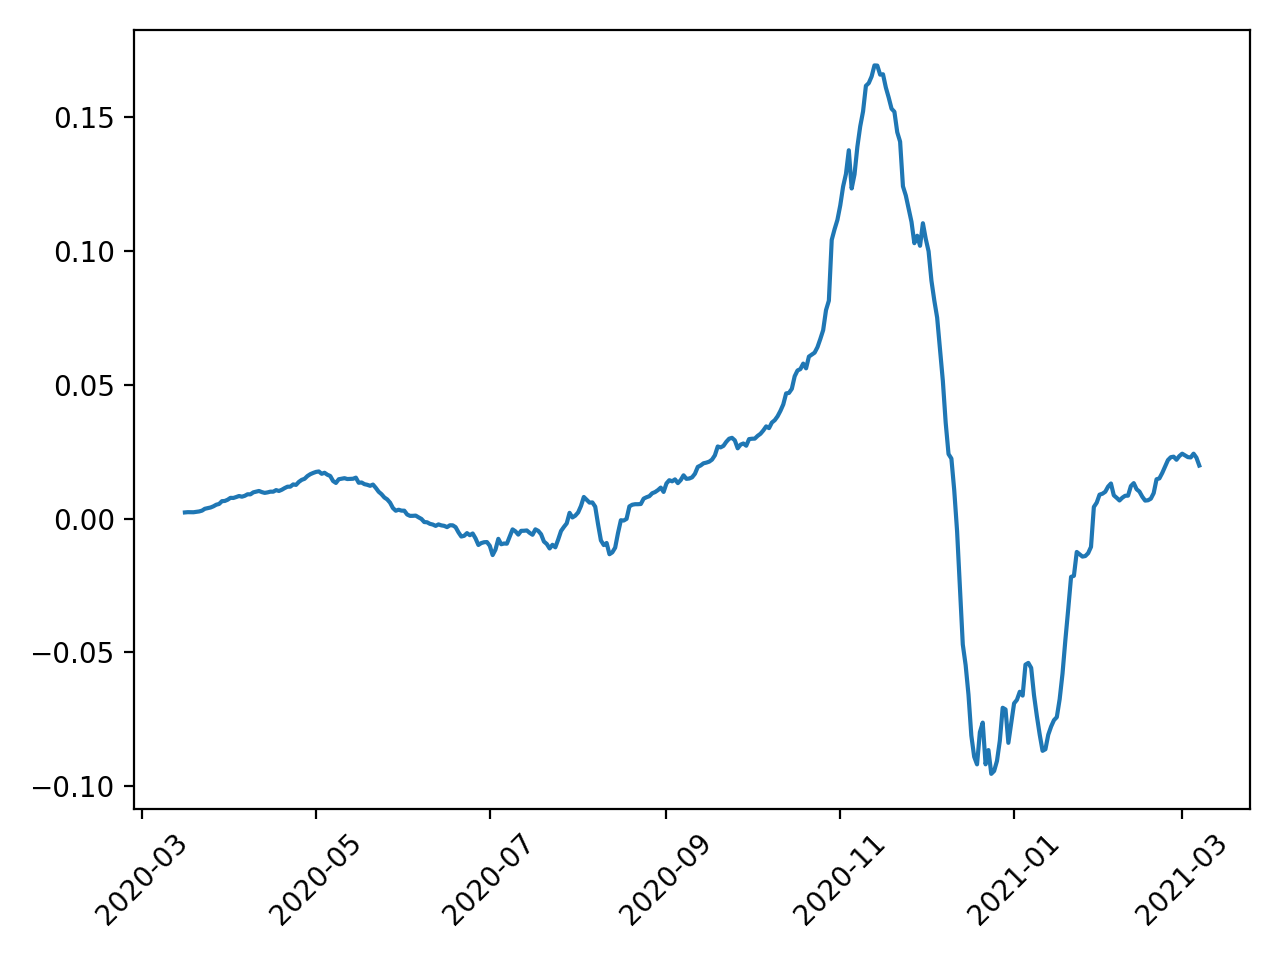

In [15]:
plt.plot(cvd.iloc[these].date2.values, -comp[1,:])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Which states did this second component make the most difference for?

In [16]:
onecomp = []
twocomp = []
for i in range(len(np.unique(cvd.state.values))):
    onecomp.append(np.sum((X[i,:] - X_transformed[i,0]*comp[0,:])**2)/np.sum(X[i,:]**2))
    twocomp.append(np.sum((X[i,:] - X_transformed[i,:2]@comp[:2,:])**2)/np.sum(X[i,:]**2))
b = np.sort(np.argsort(np.array(onecomp) - np.array(twocomp))[-11:-1])
for i in b:
    print(i,np.unique(cvd.state.values)[i])

12 GU
14 IA
24 MI
25 MN
29 MT
31 ND
32 NE
45 SD
53 WI
55 WY


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """


<IPython.core.display.Javascript object>


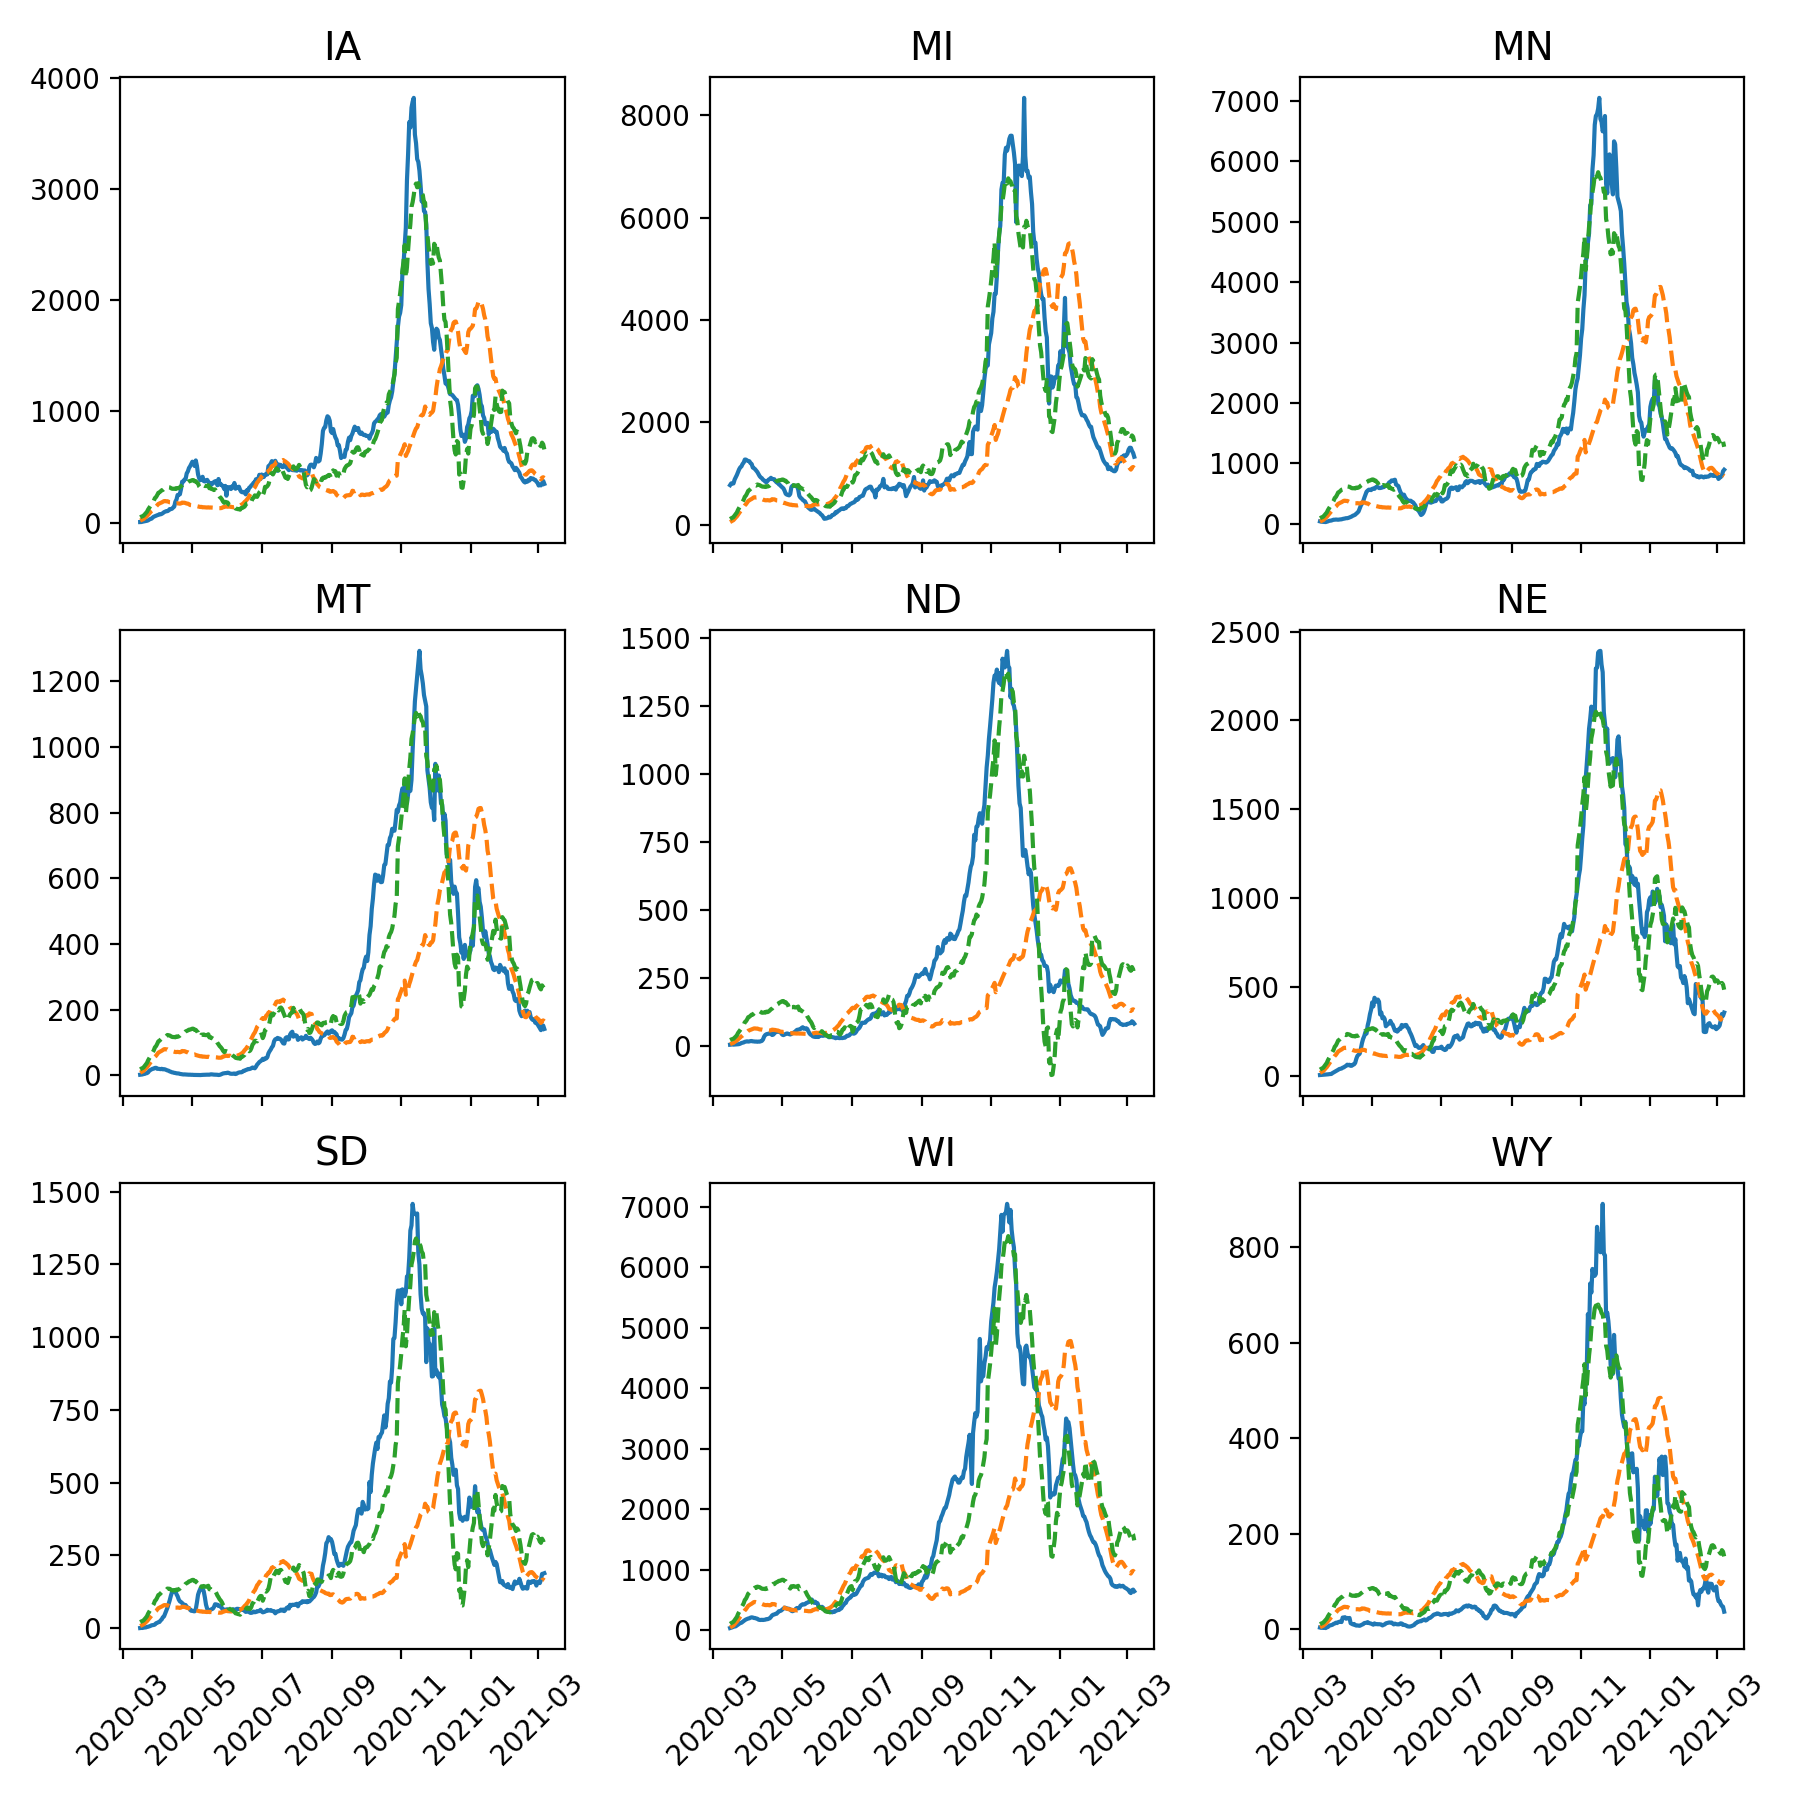

In [17]:
fig, ax = plt.subplots(3,3,sharex=True, figsize=(9,9))

for k,i in enumerate([14,24,25,29,31,32,45,53,55]):
    ax[int(k/3),k%3].plot(cvd.iloc[these].date2.values,X[i,:])
    ax[int(k/3),k%3].plot(cvd.iloc[these].date2.values,X_transformed[i,0] * comp[0,:], ls='--')
    ax[int(k/3),k%3].plot(cvd.iloc[these].date2.values,X_transformed[i,:2] @ comp[:2,:], ls='--')
    ax[int(k/3),k%3].set_title(np.unique(cvd.state.values)[i], fontsize=14)
    for tick in ax[int(k/3),k%3].get_xticklabels():
        tick.set_rotation(45)
plt.tight_layout()
plt.show()

Very interesting! So the story behind the second component is the midwest reaching the largest spike of cases a couple months before the rest of the country, but afterwards having a much more mild form of the overall winter spike.

## Third Dictionary Element

<IPython.core.display.Javascript object>


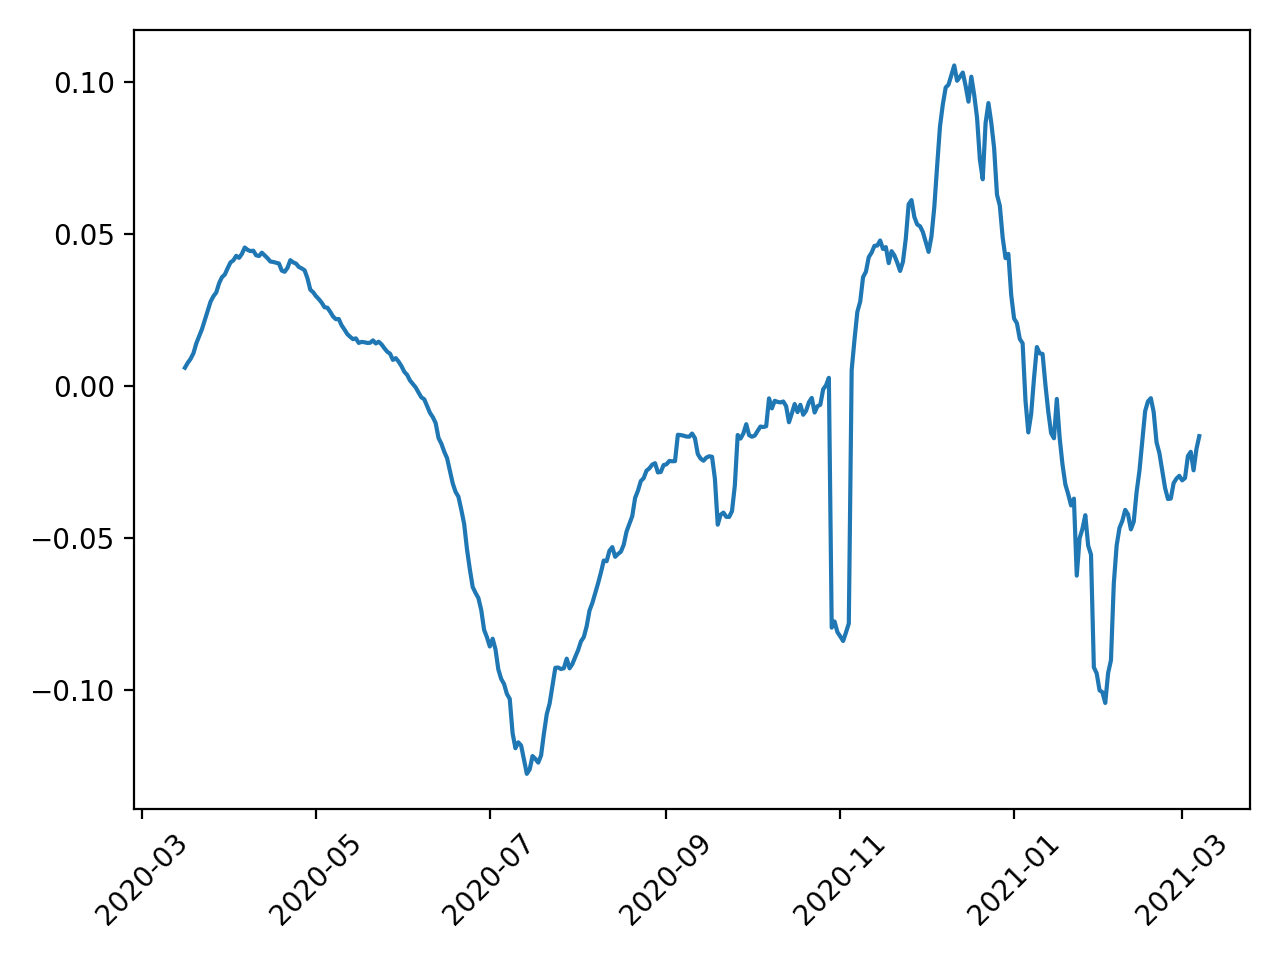

In [18]:
plt.plot(cvd.iloc[these].date2.values, comp[2,:])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Which states did this third component make the most difference for?

In [19]:
twocomp = []
threecomp = []
for i in range(len(np.unique(cvd.state.values))):
    twocomp.append(np.sum((X[i,:] - X_transformed[i,:2]@comp[:2,:])**2)/np.sum(X[i,:]**2))
    threecomp.append(np.sum((X[i,:] - X_transformed[i,:3]@comp[:3,:])**2)/np.sum(X[i,:]**2))
b = np.sort(np.argsort(np.array(twocomp) - np.array(threecomp))[-11:-1])
for i in b:
    print(i,np.unique(cvd.state.values)[i])

7 CT
10 FL
17 IN
21 MA
24 MI
41 PA
43 RI
44 SC
47 TX
50 VI


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """


<IPython.core.display.Javascript object>


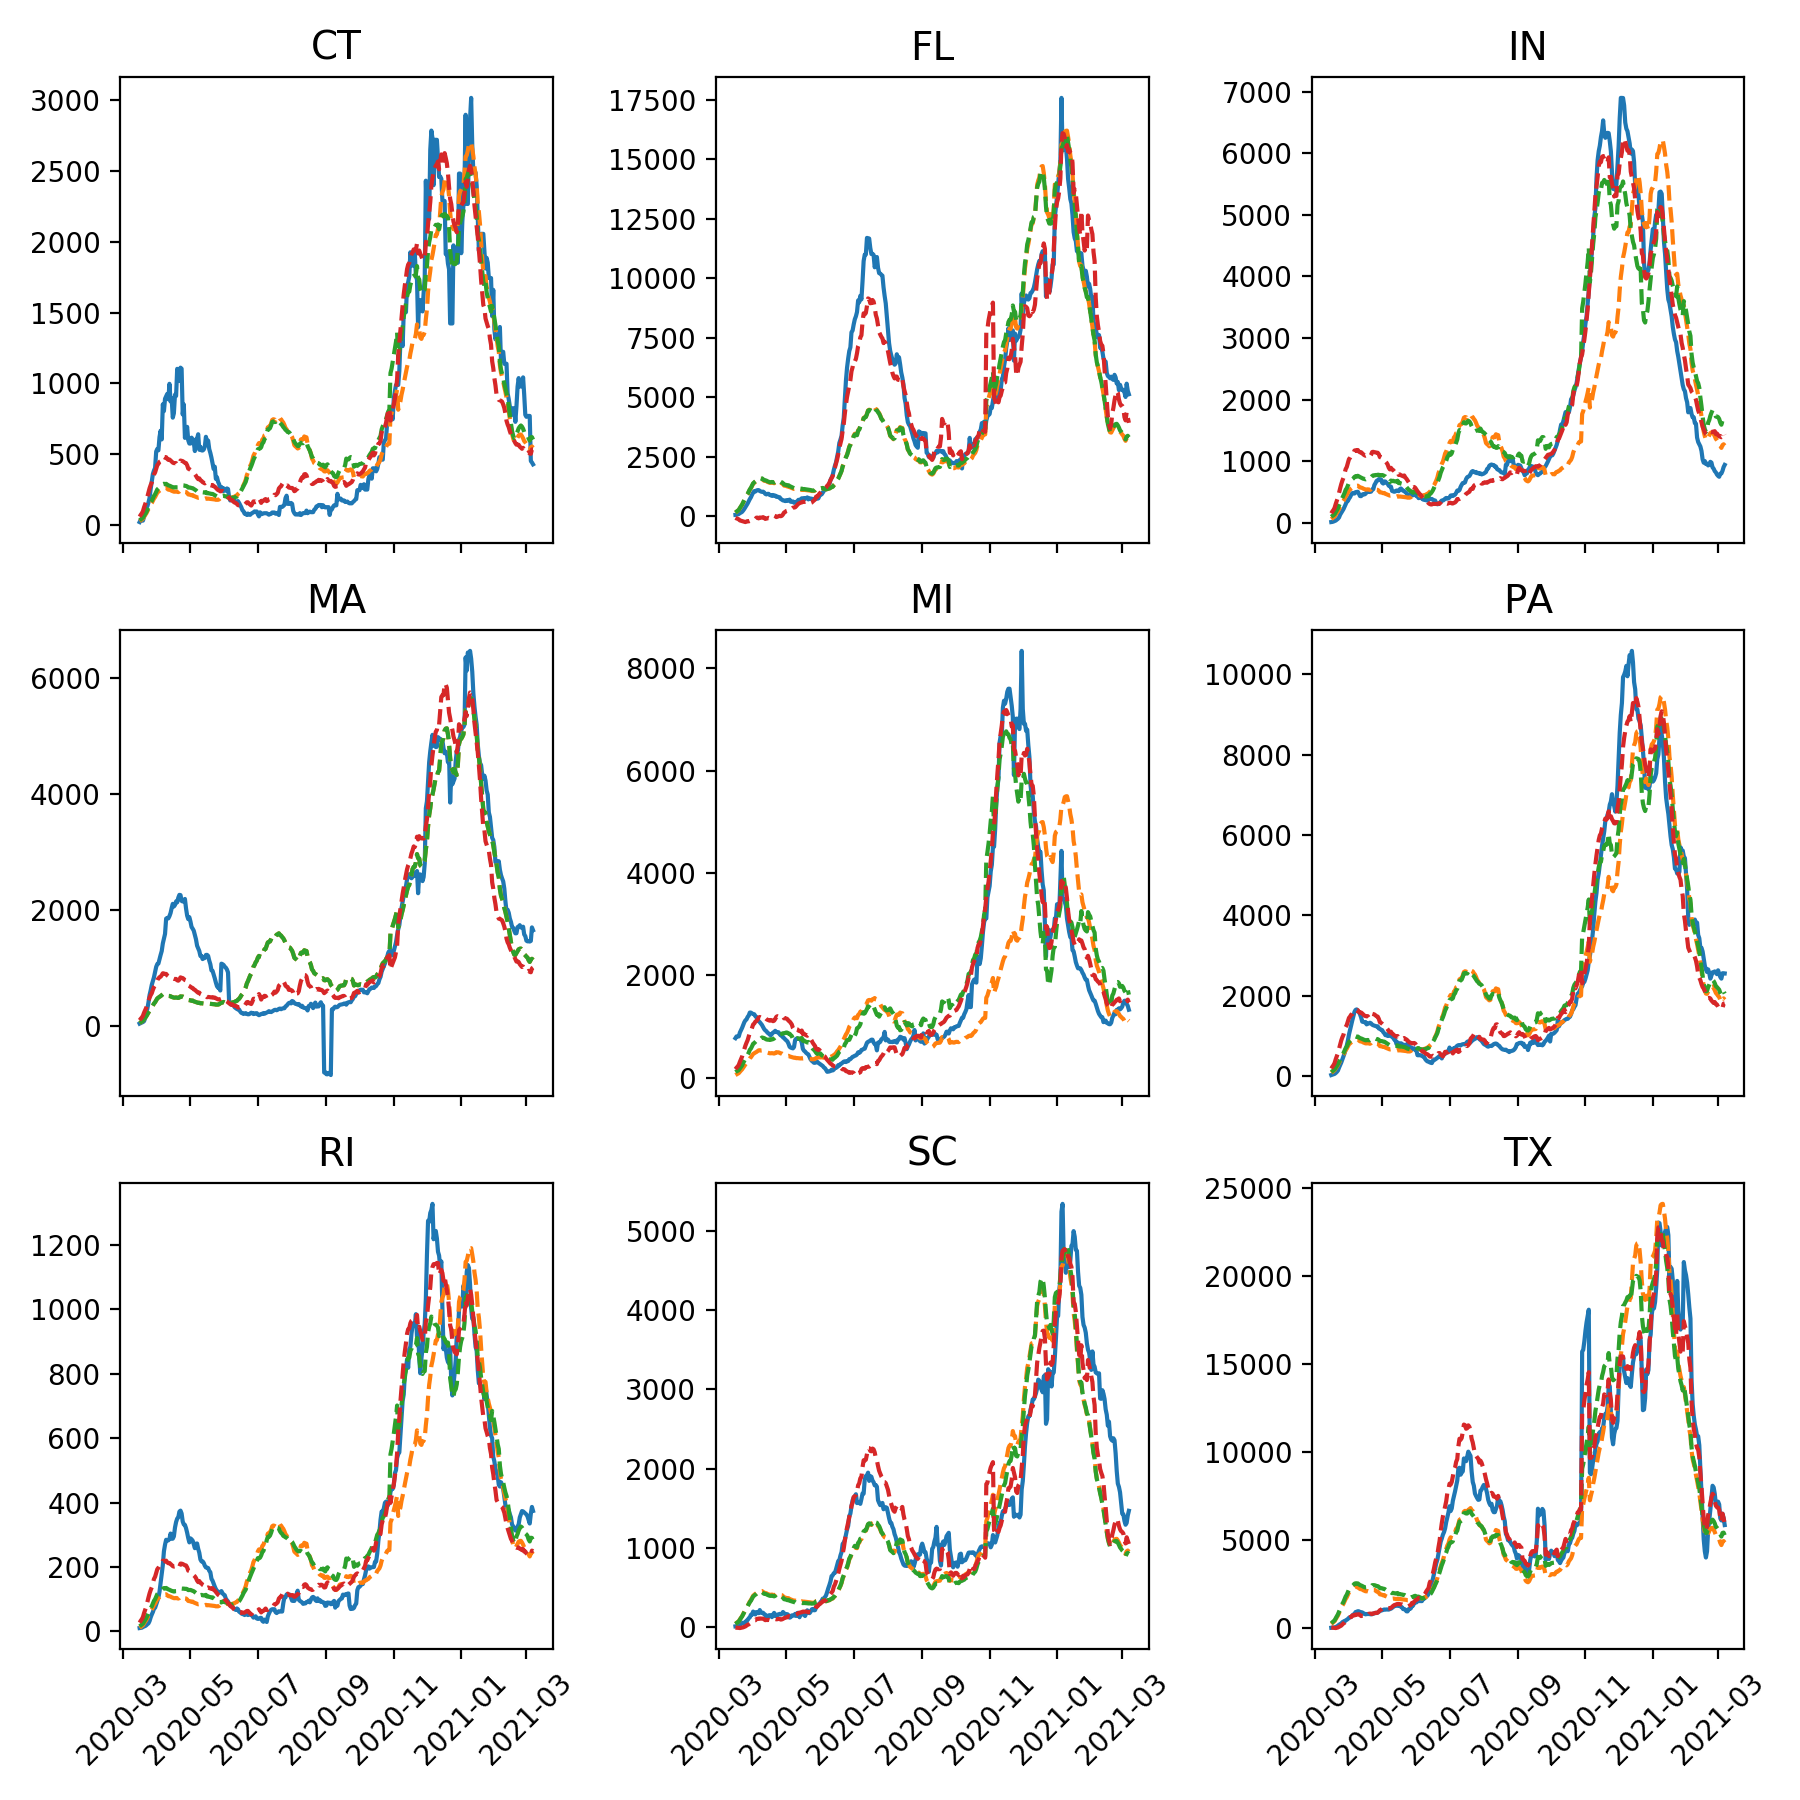

In [20]:
fig, ax = plt.subplots(3,3,sharex=True, figsize=(9,9))

for k,i in enumerate([7,10,17,21,24,41,43,44,47]):
    ax[int(k/3),k%3].plot(cvd.iloc[these].date2.values,X[i,:])
    ax[int(k/3),k%3].plot(cvd.iloc[these].date2.values,X_transformed[i,0] * comp[0,:], ls='--')
    ax[int(k/3),k%3].plot(cvd.iloc[these].date2.values,X_transformed[i,:2] @ comp[:2,:], ls='--')
    ax[int(k/3),k%3].plot(cvd.iloc[these].date2.values,X_transformed[i,:3] @ comp[:3,:], ls='--')
    ax[int(k/3),k%3].set_title(np.unique(cvd.state.values)[i], fontsize=14)
    for tick in ax[int(k/3),k%3].get_xticklabels():
        tick.set_rotation(45)
plt.tight_layout()
plt.show()

This story is a little bit more nuanced. It seems like the main message behind this third component is that some states experienced a more severe initial wave in March 2020, but a much more mild summer than the rest of the country. CT, IN, MA, MI, PA, and RI all show this characteristic. On the contrary, this component also represents the opposite scenario that played out in FL, SC, and TX: they largely avoided the initial wave, but that came back to bite when afterwards they experienced a more severe summer wave than average.

There's also a second half to this story! The first half, taking place before September, 2020, is described in the above paragraph. The second half takes place in the fall and winter afterwards. If a state experienced a more severe wave in March, 2020 this third component suggests that they also experienced the winter wave more severely than average, followed by a milder-than-average start to 2021. On the other hand, if a state managed to avoid the March, 2020 wave but in a way that increased the height of the follow-up wave in the summer, they followed a similar pattern with the December 2020 wave.

## Fourth Dictionary Element

<IPython.core.display.Javascript object>


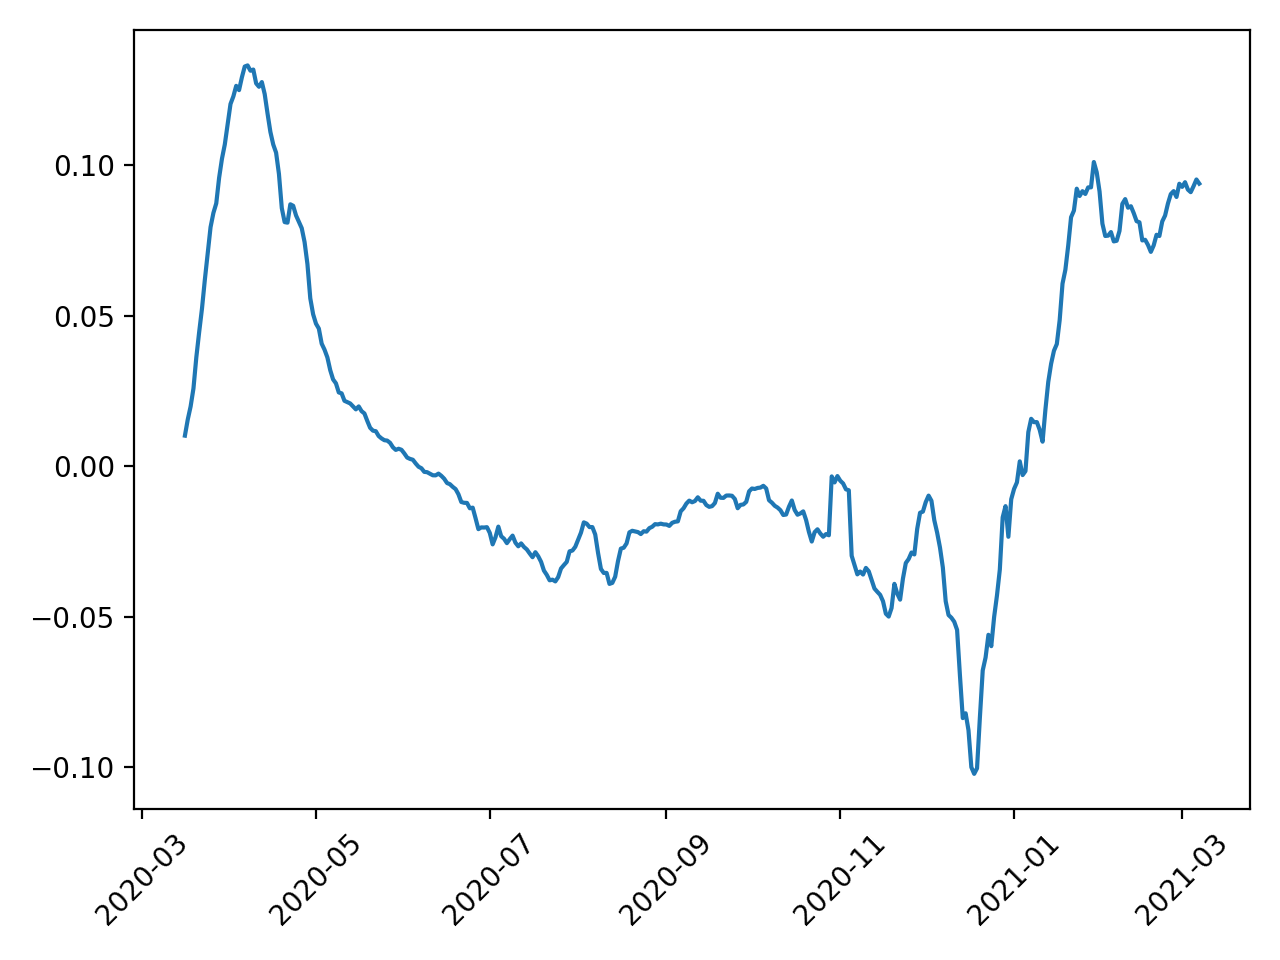

In [21]:
plt.plot(cvd.iloc[these].date2.values, -comp[3,:])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Which states did this fourth component make the most difference for?

In [22]:
threecomp = []
fourcomp = []
for i in range(len(np.unique(cvd.state.values))):
    threecomp.append(np.sum((X[i,:] - X_transformed[i,:3]@comp[:3,:])**2)/np.sum(X[i,:]**2))
    fourcomp.append(np.sum((X[i,:] - X_transformed[i,:4]@comp[:4,:])**2)/np.sum(X[i,:]**2))
b = np.sort(np.argsort(np.array(threecomp) - np.array(fourcomp))[-6:-1])
for i in b:
    print(i,np.unique(cvd.state.values)[i])

8 DC
21 MA
34 NJ
37 NY
51 VT


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """


<IPython.core.display.Javascript object>


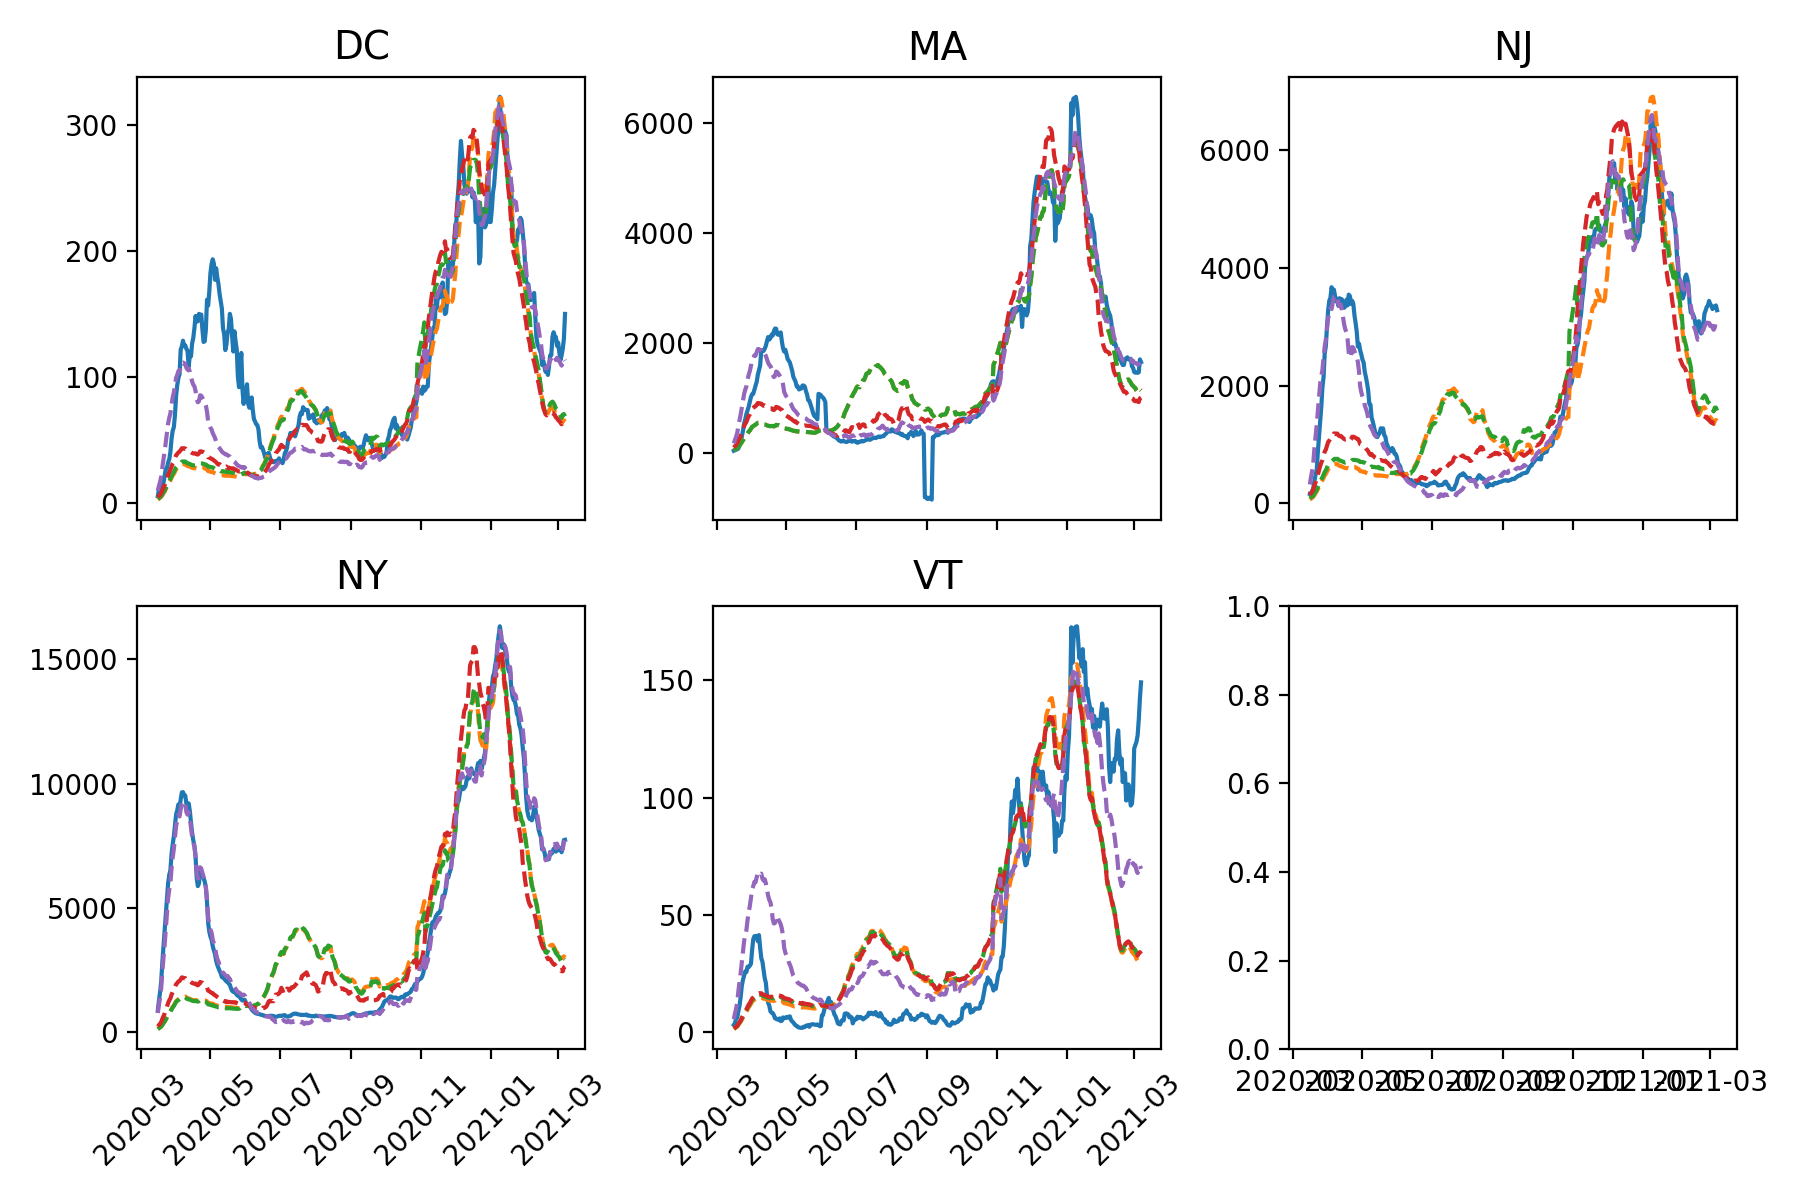

In [23]:
fig, ax = plt.subplots(2,3,sharex=True, figsize=(9,6))

for k,i in enumerate([8,21,34,37,51]):
    ax[int(k/3),k%3].plot(cvd.iloc[these].date2.values,X[i,:])
    ax[int(k/3),k%3].plot(cvd.iloc[these].date2.values,X_transformed[i,0] * comp[0,:], ls='--')
    ax[int(k/3),k%3].plot(cvd.iloc[these].date2.values,X_transformed[i,:2] @ comp[:2,:], ls='--')
    ax[int(k/3),k%3].plot(cvd.iloc[these].date2.values,X_transformed[i,:3] @ comp[:3,:], ls='--')
    ax[int(k/3),k%3].plot(cvd.iloc[these].date2.values,X_transformed[i,:4] @ comp[:4,:], ls='--')
    ax[int(k/3),k%3].set_title(np.unique(cvd.state.values)[i], fontsize=14)
    for tick in ax[int(k/3),k%3].get_xticklabels():
        tick.set_rotation(45)
plt.tight_layout()
plt.show()

Even though this component is fourth on the list, it has a prety clear and sober story to tell. This component represents the introduction of the virus to a place in the country where it rapidly spread. NY, NJ, and MA all experienced one of the most life-taking versions of the March, 2020 wave. Another sobering part is that almost a year later these same states, after having a slightly milder version of the pandemic overall on average, experienced a more rapidly spreading virus than the rest of the country: the British variant

<IPython.core.display.Javascript object>


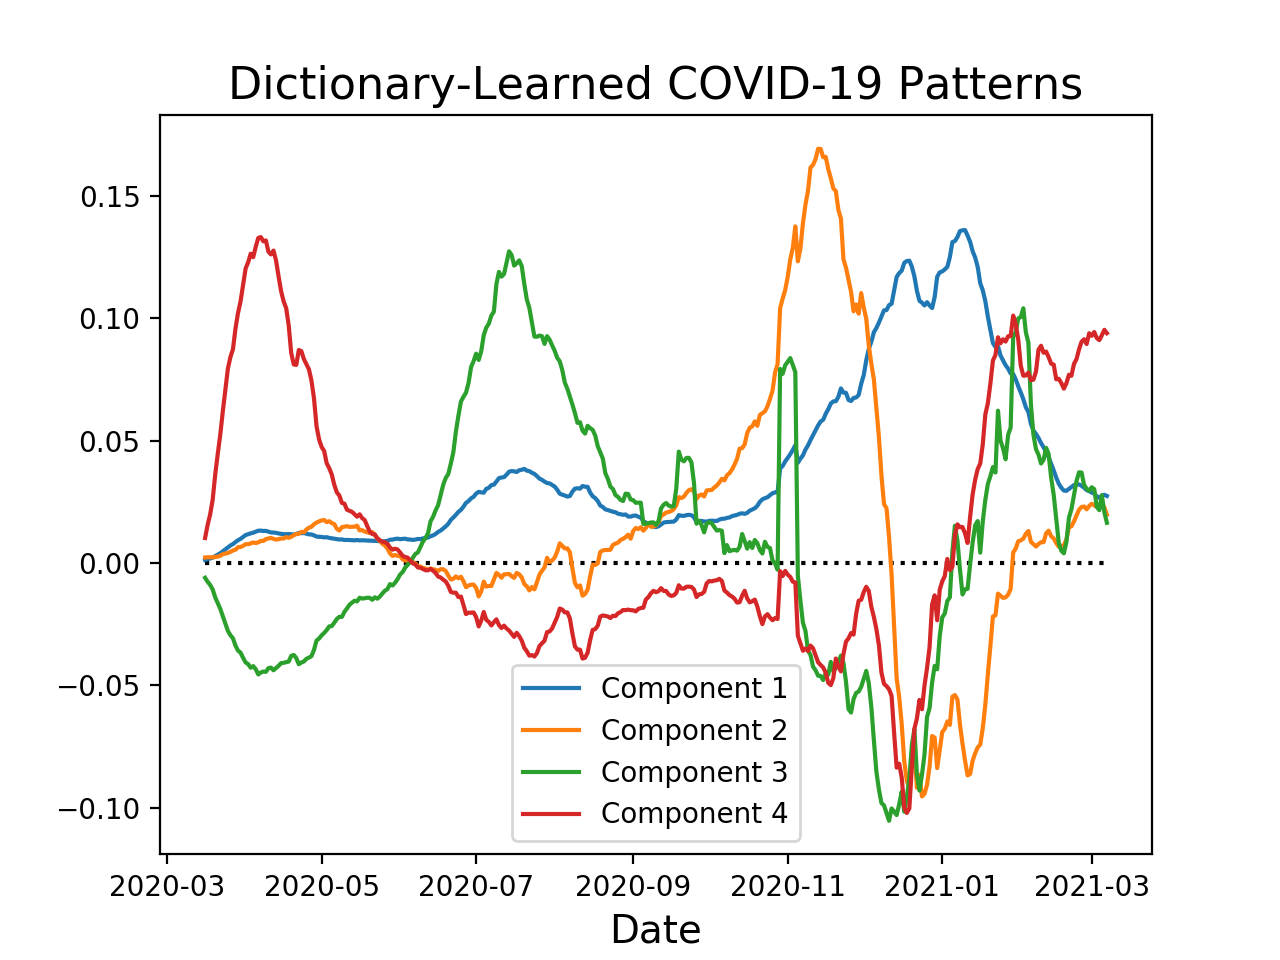

In [24]:
for k in range(4):
    plt.plot(cvd.iloc[these].date2.values, -comp[k,:], label="Component %d"%int(k+1))
plt.hlines([0], xmin = np.min(cvd.iloc[these].date2.values), xmax = np.max(cvd.iloc[these].date2.values), color='k',
           ls=':')
plt.legend(loc='best')
plt.xlabel("Date", fontsize=14)
plt.title("Dictionary-Learned COVID-19 Patterns", fontsize=16)
plt.savefig("COVID19-dictlearning_components.png")
plt.show()